# Practicel ML - KNN

### Full Name : Danial Ataee
### Student Number : 99100455

In this Notebook, we will implement KNN for the given dataset. This notebook has 3 phases, in the first phase we explore dataset, in the second phase we preprocess the dataset and in the last phase we implement KNN from scratch and also with sklearn and train it on the dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

Inspect the first rows of the dataframe

In [2]:
data = pd.read_csv('train.csv')
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,29,No,Travel_Rarely,592,Research & Development,7,3,Life Sciences,1,1883,...,2,80,0,11,2,3,3,2,1,2
1,36,No,Travel_Rarely,884,Sales,1,4,Life Sciences,1,1585,...,1,80,0,15,5,3,1,0,0,0
2,34,No,Travel_Rarely,1326,Sales,3,3,Other,1,1478,...,4,80,0,15,2,3,13,9,3,12
3,27,No,Travel_Rarely,954,Sales,9,3,Marketing,1,1965,...,1,80,0,7,5,3,7,7,0,7
4,32,No,Travel_Rarely,929,Sales,10,3,Marketing,1,722,...,4,80,0,10,2,2,10,7,0,8


Calculate the number of samples

In [3]:
len(data)

1102

Measure the number of unique values for each column. Note that Attrition is the target column.

In [4]:
data.nunique()

Age                           43
Attrition                      2
BusinessTravel                 3
DailyRate                    736
Department                     3
DistanceFromHome              29
Education                      5
EducationField                 6
EmployeeCount                  1
EmployeeNumber              1102
EnvironmentSatisfaction        4
Gender                         2
HourlyRate                    71
JobInvolvement                 4
JobLevel                       5
JobRole                        9
JobSatisfaction                4
MaritalStatus                  3
MonthlyIncome               1027
MonthlyRate                 1082
NumCompaniesWorked            10
Over18                         1
OverTime                       2
PercentSalaryHike             15
PerformanceRating              2
RelationshipSatisfaction       4
StandardHours                  1
StockOptionLevel               4
TotalWorkingYears             40
TrainingTimesLastYear          7
WorkLifeBa

Check if there is a column with less than two unique values. If such a columns exists, remove it!

In [5]:
data.drop(data.columns[data.nunique() == 1], axis=1, inplace=True)

Plot Mean BusinessTravel against Age. Note: Since the BusinessTravel column is categorical, you should first consider another column corresponding to each unique value BusinessTravel takes. For instance, you may assume that if someone does not travel, the value of the column for this person is 0.

{'Travel_Rarely': 0, 'Travel_Frequently': 1, 'Non-Travel': 2}


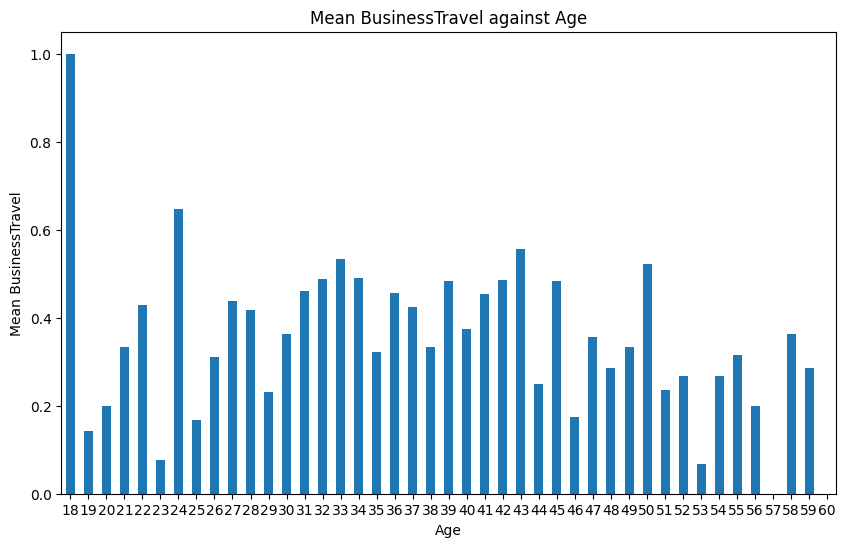

In [6]:
# Replace each unique value in BusinessTravel with a number starting from 0
business_travel_mapping = {val: i for i, val in enumerate(data['BusinessTravel'].unique())}
print(business_travel_mapping)

data['BusinessTravel'] = data['BusinessTravel'].map(business_travel_mapping)

# Compute mean BusinessTravel against Age
mean_business_travel_age = data.groupby('Age')['BusinessTravel'].mean()

# Plot
mean_business_travel_age.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Age')
plt.ylabel('Mean BusinessTravel')
plt.title('Mean BusinessTravel against Age')
plt.xticks(rotation=0)
plt.show()

Check if there seems to be a meaningful relationship between people's age and the years they have worked with their current manager. Your result should be a plot.

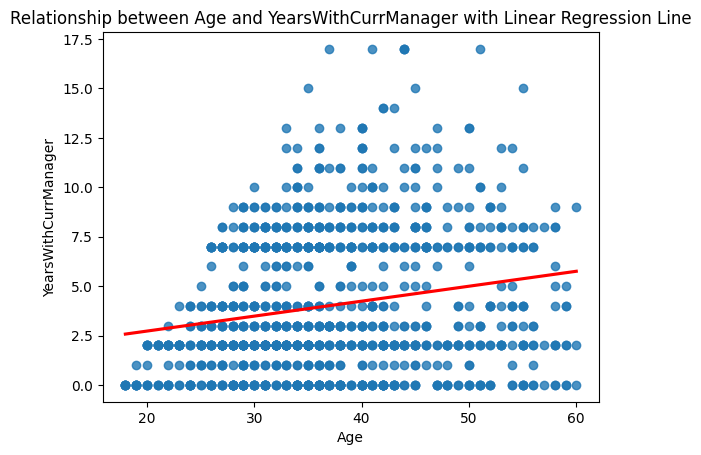

In [7]:
ax = sns.regplot(x='Age', y='YearsWithCurrManager', data=data, ci=None)
ax.get_lines()[0].set_color('red')
plt.xlabel('Age')
plt.ylabel('YearsWithCurrManager')
plt.title('Relationship between Age and YearsWithCurrManager with Linear Regression Line')
plt.show()

As we can see, there is no specific relationship between these two values, because the dots are everywhere. Even if there is a correlation, the variance is high.

Plot the average MonthlyIncome against the YearsAtCompany. 

c:\Users\Dan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Dan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Dan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Dan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is de

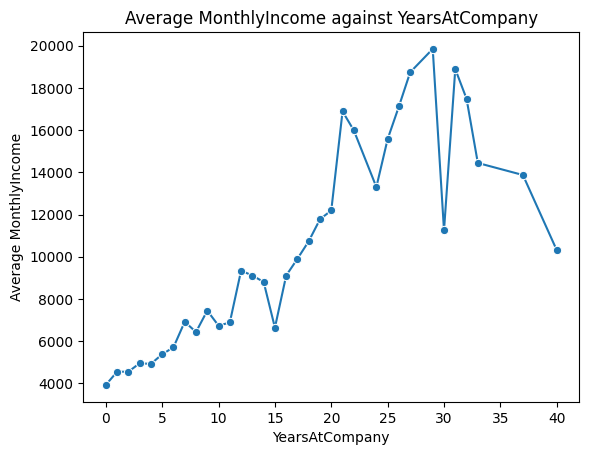

In [8]:
average_monthly_income_years_at_company = data.groupby('YearsAtCompany')['MonthlyIncome'].mean().reset_index()

sns.lineplot(x='YearsAtCompany', y='MonthlyIncome', data=average_monthly_income_years_at_company, marker='o')
plt.xlabel('YearsAtCompany')
plt.ylabel('Average MonthlyIncome')
plt.title('Average MonthlyIncome against YearsAtCompany')
plt.show()

## Preprocessing

Label encode all categorical columns and split the data into train and test parts. The training part will further splitted into train and validation parts.

Split the test and validation dataframe into feature and label part, Attrition columns is the target columns and rest of the columns should be treated as features.

In [9]:
# Label encode categorical columns
encoder = LabelEncoder()
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = encoder.fit_transform(data[col])

train_val_df, test_df = train_test_split(data,test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

X_train = train_df.drop(columns=['Attrition'])
y_train = train_df['Attrition']
X_val = val_df.drop(columns=['Attrition'])
y_val = val_df['Attrition']
X_test = test_df.drop(columns=['Attrition'])
y_test = test_df['Attrition']

# Shapes of train, validation, and test data
print("Train data shape:", X_train.shape, y_train.shape)
print("Validation data shape:", X_val.shape, y_val.shape)
print("Test data shape:", X_test.shape, y_test.shape)

Train data shape: (704, 31) (704,)
Validation data shape: (177, 31) (177,)
Test data shape: (221, 31) (221,)



# Model Implementation From Scratch
  

## How the algorithm works

**We calculate the euclidean distance between a new sample and all points**

**We determine the label of the sample based on the majority vote**

## Key Points:

### Euclidean Distance
**Euclidean distance is defined as the distance between two points**

Where it's represented by this equation :
$$\sqrt{\sum\limits_{i = 0}^{m-1} (x - y)^2}$$


In [10]:
class KNN:
    def __init__(self, k=3):
        """
        Initialize the KNN classifier.

        Parameters:
        - k (int): Number of neighbors to consider.
        """
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X_train, y_train):
        """
        Fit the KNN classifier to the training data.

        Parameters:
        - X_train (DataFrame): Training feature vectors.
        - y_train (Series): Training labels.
        """
        self.X_train = X_train
        self.y_train = y_train

    def euclidean_distance(self, x1, x2):
        """
        Calculate the distance between two data points.

        Parameters:
        - x1 (numpy array): First data point.
        - x2 (numpy array): Second data point.

        Returns:
        - float: Distance between x1 and x2.
        """
        return np.sqrt(np.sum((x1 - x2)**2))

    def predict(self, X_test):
        """
        Predict labels for test data.

        Parameters:
        - X_test (DataFrame): Test feature vectors.

        Returns:
        - numpy array: Predicted labels.
        """
        y_pred = [self._predict(x) for x in X_test.to_numpy()]
        return np.array(y_pred)

    def _predict(self, x):
        """
        Predict label for a single data point.

        Parameters:
        - x (numpy array): Test data point.

        Returns:
        - int: Predicted label.
        """
        distances = [self.euclidean_distance(x, x_train) for x_train in self.X_train.to_numpy()]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train.iloc[i] for i in k_indices]
        most_common = np.bincount(k_nearest_labels).argmax()
        return most_common


# Evaluation
  

Define the model and train it.

In [11]:
# Grid of k values
k_values = range(5, 31, 5)

# Dictionary to store accuracies for each k on validation set
val_accuracies = {}

# Train the model for each value of k and evaluate on the validation set
for k in k_values:
    knn_model = KNN(k=k)
    knn_model.fit(X_train, y_train)
    y_val_pred = knn_model.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)
    val_accuracies[k] = accuracy

# Find the best value of k based on validation accuracy
best_k = max(val_accuracies, key=val_accuracies.get)
print("Best k:", best_k)
print("Validation Accuracy for best k:", val_accuracies[best_k])

# Train the model with the best k on the combined training and validation data
best_knn_model = KNN(k=best_k)
X_train_combined = pd.concat([X_train, X_val])
y_train_combined = pd.concat([y_train, y_val])
best_knn_model.fit(X_train_combined, y_train_combined)

Best k: 10
Validation Accuracy for best k: 0.8135593220338984


Predict the y_train and y_test values.

In [12]:
# Evaluate the best model on the training, validation, and test sets
y_train_pred = best_knn_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

y_val_pred = best_knn_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", val_accuracy)

y_test_pred = best_knn_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

Training Accuracy: 0.8451704545454546
Validation Accuracy: 0.8248587570621468
Test Accuracy: 0.8235294117647058


# Sklearn Implementation
  

Define the sklearn knn model and fit to the training data

In [13]:
# Dictionary to store accuracies for each k on validation set
val_accuracies = {}

# Train the model for each value of k and evaluate on the validation set
for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)
    y_val_pred = knn_model.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)
    val_accuracies[k] = accuracy

# Find the best value of k based on validation accuracy
best_k = max(val_accuracies, key=val_accuracies.get)
print("Best k:", best_k)
print("Validation Accuracy for best k:", val_accuracies[best_k])

# Train the model with the best k on the combined training and validation data
best_knn_model = KNeighborsClassifier(n_neighbors=best_k)
X_train_combined = pd.concat([X_train, X_val])
y_train_combined = pd.concat([y_train, y_val])
best_knn_model.fit(X_train_combined, y_train_combined)

Best k: 10
Validation Accuracy for best k: 0.8135593220338984


KNeighborsClassifier(n_neighbors=10)

Now predict the defined model on test data and return the accuracy

In [14]:
# Evaluate the best model on the training, validation, and test sets
y_train_pred = best_knn_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

y_val_pred = best_knn_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", val_accuracy)

y_test_pred = best_knn_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

Training Accuracy: 0.8451704545454546
Validation Accuracy: 0.8248587570621468
Test Accuracy: 0.8235294117647058


# Thank You


**Thank you for taking your time going through this notebook**

**If you have any feedback please let me know**